# Context of this project

We want to build a movies' recommender in order to get new movies to watch during the lock down. We will base our work on a variation of the MovieLens dataset. 
The data consists of movies seen by the users, some informations about the movies, and some informations about the users. The problem consists in predicting which movies a given user might like.

We are presenting you here first a naive approach in order to familarize yourself with the problem and show you how it might be solved.

# Libraries & APIs

In [320]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [501]:
# For styling the figures.

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Importing the Data

First, let's load some data.

In [66]:
def getDataset(path):
    
    data = pd.read_csv(path)
    print("Dataset Shape : ",data.shape)        
    return data

In [67]:
path_users = "data/users.csv"
users = getDataset(path_users)

Dataset Shape :  (6040, 5)


In [68]:
path_movies = "data/movies.csv"
movies = getDataset(path_movies)

Dataset Shape :  (3883, 21)


In [69]:
path_ratings = "data/ratings.csv"
ratings = getDataset(path_ratings)

Dataset Shape :  (1000209, 3)


# Content-based Filtering

Content-based filtering uses item features to recommend other items similar to what the user likes, based on their previous actions or explicit feedback. We dont use other users information !

For example, if user `A` liked `Harry Potter 1`, he/she will like `Harry Potter 2`

In [502]:
%%html
<img src='https://miro.medium.com/max/1642/1*BME1JjIlBEAI9BV5pOO5Mg.png' height="300" width="250"/>

What are similar movies ? In order to answer to this question we need to build a similiarity measure. 

## Features

This measure will operate on the characteristics (**features**) of the movies to determine which are close. In our case, we have access to the genres of the movies. For example, the genres of `Toy Story` are: `Animation`, `Children's` and `Comedy`. This is represented as follow in our dataset:

In [71]:
genre_cols = ["Animation", "Children's", 
       'Comedy', 'Adventure', 'Fantasy', 'Romance', 'Drama',
       'Action', 'Crime', 'Thriller', 'Horror', 'Sci-Fi', 'Documentary', 'War',
       'Musical', 'Mystery', 'Film-Noir', 'Western']

genre_and_title_cols = ['title'] + genre_cols 

movies[genre_and_title_cols].head()

,title,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,Toy Story,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Jumanji,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Grumpier Old Men,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Waiting to Exhale,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Father of the Bride Part II,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Similarity

Now that we have some features, we will try to find a function that performs a similiarity measure. The Similarity function will take two items (two list of features) and return a number proportional to their similarity. 

For the following we will consider that the Similarity between two movies is the number of genres they have in common.

Here is an example with `Toy Story` and `E.T`

In [72]:
def getMovieGenres(movieTitle, possibleGenres,columnsToselect, data):
    
    """ This function returns the genders of a given movie (title)."""
    
    movie_genres = data[columnsToselect].loc[data["title"] == movieTitle][possibleGenres].iloc[0]    
    return movie_genres


####################################################


def computeSimilarity(movie_1_genres, movie_2_genres):
    
    """ Since we compute a naive similarity, we do a basic scalar product between the two genres vectors."""
    
    np_movie_1 = movie_1_genres.to_numpy()
    np_movie_2 = movie_2_genres.to_numpy()

    similarity = (np_movie_1 * np_movie_2).sum()
    
    print("The similarity between those two movies is : ",similarity)
    
    return similarity

In [73]:
movieTitle = "Toy Story"
toy_story_genres = getMovieGenres(movieTitle, genre_cols, genre_and_title_cols, movies)

In [74]:
movieTitle = "E.T. the Extra-Terrestrial"
et_genres = getMovieGenres(movieTitle, genre_cols, genre_and_title_cols, movies)

In [75]:
similarity_1 = computeSimilarity(et_genres, toy_story_genres)

The similarity between those two movies is :  1.0


So our similarity measure returns `1.0` for these two movies. 

Let's see another example where we compare `Toy Stories` and `Pocahontas`

In [76]:
movieTitle = "Pocahontas"
pocahontas_genres = getMovieGenres(movieTitle, genre_cols, genre_and_title_cols, movies)

In [77]:
similarity_2 = computeSimilarity(pocahontas_genres, toy_story_genres)

The similarity between those two movies is :  2.0


This tels us that `Pocahontas` is closer to `Toy Stories` than `E.T.` which makes sense.


## Scaling up

Ok, that's a nice measure. Now we are going to scale it up to all movies of our dataset. To do so smartly, let's take a look at the operation we just did, but from a mathematical point of view. To do so, we will think of the list of features of a movie as a vector `V`. Then, our similarity measure between `Toy Story` and `E.T.` becomes:
$ V_{ToyStory} \cdot V_{ET}^{T}$

More generally the similarity measure between a movie `i` and another movie `j` is : $ V_{i} \cdot V_{j}^{T}$

Now we can think of `movies` as a matrix containing all features vectors describing the movies. Here is how our similiarity measure looks in this context:

![](imgs/dot_product_matrices.png)

To obtain the similiarity between all movies of our dataset we have to perform the dot product of the `movies` matrix with the transposed of the `movies` matrix.

In [78]:
def computeAllSimilarities(data, genre_cols):
    
    """ Updated version to compute the naive similarity, we do a basic scalar product between data and its transpose."""
    
    data_np = data[genre_cols].to_numpy()
    
    return np.dot(data_np, data_np.T)


####################################################


def printSimilarityOneMovie(data, similaritiesVector, movieTitle, N):
    
    """ This function prints the similarities for a given vector of similarity."""

    for i in range(N):
        
        print("Similarity between ", movieTitle, " and ", data.iloc[i]['title'], " (index ",i, ") is ", similaritiesVector[i])

In [79]:
similarity = computeAllSimilarities(movies, genre_cols)
similarity.shape

(3883, 3883)

In [442]:
similarity

array([[3., 1., 1., ..., 0., 0., 0.],
       [1., 3., 0., ..., 0., 0., 0.],
       [1., 0., 2., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 2.]])

We can now get the similarity between `Toy Story` and any other movie of our dataset

In [80]:
similarity_with_toy_story = similarity[0] # index 0 is Toy Story
similarity_with_toy_story

array([3., 1., 1., ..., 0., 0., 0.])

In [96]:
printSimilarityOneMovie(movies, similarity_with_toy_story, "Toy story", 10)

Similarity between  Toy story  and  Toy Story  (index  0 ) is  3.0
Similarity between  Toy story  and  Jumanji  (index  1 ) is  1.0
Similarity between  Toy story  and  Grumpier Old Men  (index  2 ) is  1.0
Similarity between  Toy story  and  Waiting to Exhale  (index  3 ) is  1.0
Similarity between  Toy story  and  Father of the Bride Part II  (index  4 ) is  1.0
Similarity between  Toy story  and  Heat  (index  5 ) is  0.0
Similarity between  Toy story  and  Sabrina  (index  6 ) is  1.0
Similarity between  Toy story  and  Tom and Huck  (index  7 ) is  1.0
Similarity between  Toy story  and  Sudden Death  (index  8 ) is  0.0
Similarity between  Toy story  and  GoldenEye  (index  9 ) is  0.0


## A bit of polishing

### Helpers

We also built some helpers to handle the movies dataset:

In [97]:
from content_based_filtering.helpers.movies import get_movie_id, get_movie_name, get_movie_year

### Finding similar movies:
Here is a method giving us the movie the most similar to another movie:

In [169]:
def get_most_similar(similarity, movie_name, year=None, top=10):
    
    index_movie = get_movie_id(movies, movie_name, year)
    best = similarity[index_movie].argsort()[::-1]
    
    return [(ind, get_movie_name(movies, ind), similarity[index_movie, ind]) for ind in best[:top] if ind != index_movie]

In [144]:
get_most_similar(similarity, movies, 'Toy Story')

[(667, 'Space Jam', 3.0),
 (3685, 'Adventures of Rocky and Bullwinkle, The', 3.0),
 (3682, 'Chicken Run', 3.0),
 (2009, 'Jungle Book, The', 3.0),
 (2011, 'Lady and the Tramp', 3.0),
 (2012, 'Little Mermaid, The', 3.0),
 (2033, 'Steamboat Willie', 3.0),
 (2072, 'American Tail, An', 3.0),
 (2073, 'American Tail: Fievel Goes West, An', 3.0)]

In [146]:
get_most_similar(similarity, movies, 'Psycho', 1960, 15) 

[(3593, "Puppet Master III: Toulon's Revenge", 2.0),
 (2923, 'Rawhead Rex', 2.0),
 (1312, 'Believers, The', 2.0),
 (3407, "Jacob's Ladder", 2.0),
 (1957, 'Disturbing Behavior', 2.0),
 (1927, 'Poltergeist III', 2.0),
 (1926, 'Poltergeist II: The Other Side', 2.0),
 (1925, 'Poltergeist', 2.0),
 (732, 'Thinner', 2.0),
 (69, 'From Dusk Till Dawn', 2.0),
 (1300, 'Alien�', 2.0),
 (2246, 'Bride of Chucky', 2.0),
 (2269, 'I Still Know What You Did Last Summer', 2.0),
 (2644, 'Lake Placid', 2.0),
 (3639, 'Firestarter', 2.0)]

### Giving a recommendation:

And finally, let's find some movies to recommend based on previously liked movies:

In [194]:
def get_recommendations(user_id, ratings, movies):
    
    #top_movies = ratings[ratings['user_id'] == user_id].sort_values(by='rating', ascending=False).head(3)['movie_id']
    
    top_movies = ratings[ratings['user_id'] == user_id].sort_values(by='rating', ascending=False)['movie_id']
    
    index=['movie_id', 'title', 'similarity']

    most_similars = []
    
    for top_movie in top_movies:
        most_similars += get_most_similar(similarity, get_movie_name(movies, top_movie), get_movie_year(movies, top_movie))

    return pd.DataFrame(most_similars, columns=index).drop_duplicates().sort_values(by='similarity', ascending=False).head(5)

In [195]:
get_recommendations(0, ratings, movies)

,movie_id,title,similarity
193,2009,"Jungle Book, The",4.0
197,2033,Steamboat Willie,4.0
295,667,Space Jam,4.0
486,2337,Romancing the Stone,4.0
294,105,Muppet Treasure Island,4.0


In [377]:
get_recommendations(999, ratings, movies)

,movie_id,title,similarity
713,2011,Lady and the Tramp,5.0
472,2012,"Little Mermaid, The",5.0
266,1933,Lethal Weapon 3,4.0
398,1113,Escape from New York,4.0
519,2336,"Jewel of the Nile, The",4.0


# Performances evaluation

To penalize our recommandation model , the way we compute the **mean error of recommandation**, we compute the difference between the computed similarity and the rating the user gave to this movie.

$$recommandation_{error} = \frac{1}{N} \left | rating - similarity \right |$$

**Remark** : Please keep in mind that we Compute the mean error for the movies the user already rated, since we are in an unsupervised framework.

In [295]:
def computeAbsErr(recommendedMovies, recommendations, user_rating) : 

    error = 0
    cpt = 0
    
    for v in recommendedMovies :

        bool = True

        # Recommendations dataset
        s = recommendations[ recommendations['movie_id'].values == v ]["similarity"]
        
        # If we have a label for this movie_id in the recommendations set
        if(len(s)>0) :
            s = recommendations[ recommendations['movie_id'].values == v ].iloc[0]["similarity"]
        
        
            # Rating dataset
            r = user_rating[ user_rating['movie_id'].values == v ]["rating"]
            
            # If we have a label for this movie_id in the rating dataset
            if(len(r)>0) :
                r = user_rating[ user_rating['movie_id'].values == v ].iloc[0]["rating"]
            else : 
                bool = False

        else : 
                bool = False

        # If both values are present (means the users already rated this movie and we computed the similarity)
        if(bool):
            cpt = cpt + 1
            error = error + np.abs(s-r)
    
    if cpt :
        mean_err = error/cpt
    else :
        mean_err = error

    return mean_err

##################################################

def computeErrors(ratings, movies, user_id, withPrint=1) :
    
    """This function computes the error defined above for one user.
        @param withPrint : boolean to print or not. Used to print when we compute for only one user if needed.
    """

    # Compute recommendations
    recommendations = get_recommendations(user_id, ratings, movies)
    recommendations = recommendations.drop(['title'], axis=1)
    
    # The movies we recommended
    recommendedMovies = recommendations['movie_id'].values
    
    # The rating our given user gave to all movies
    user_rating = ratings[ ratings['user_id'].values == user_id ]
    
    # Compute the mean error for the movies the user already rated
    mean_err = computeAbsErr(recommendedMovies, recommendations, user_rating)
    
    if(withPrint) :
        print("The mean error in recommandation for user ",user_id," is : ", mean_err)
        
    return mean_err

In [296]:
mean_err = computeErrors(ratings, movies, 999)

The mean error in recommandation for user  999  is :  1.5


In [307]:
from tqdm import tqdm

In [498]:
def computeAllRecommendationsErr(ratings, movies, users):
    
    users_id = users['user_id'].drop_duplicates().values
    N = len(users_id)
    users_err = []

    err = 0   
    
    for i in tqdm(range(N)) :
        user_id = users_id[i]
        user_error = computeErrors(ratings, movies, user_id, False)
        err = err + user_error
        users_err.append(user_error)
        
    mean_err = err/N
    
    print("The mean error in recommandation for all user is ", mean_err)
    
    return mean_err, users_err

In [519]:
mean_err, users_err = computeAllRecommendationsErr(ratings, movies, users)

100%|████████████████████████████████████████████████████████████████████████████| 6040/6040 [1:00:27<00:00,  1.67it/s]

The mean error in recommandation for all user is  0.48317052980132436


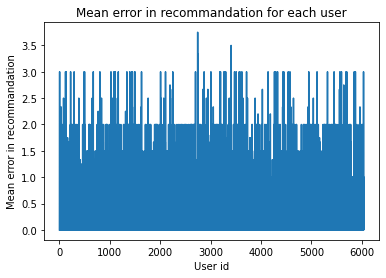

In [520]:
plt.plot(users_err)
plt.xlabel("User id")
plt.ylabel("Mean error in recommandation")
plt.title("Mean error in recommandation for each user")
plt.show()

In [537]:
users_err_np = np.array(users_err)
err_greater_than_2 = np.array([users_err_np >= 2]).sum()
print("The total prediction with more than 2 in the defined error are : ",err_greater_than_2)
print("The percentage of prediction with more than 2 in the defined error are : ",(err_greater_than_2/len(users_err_np))*100, "%")

The total prediction with more than 2 in the defined error are :  330
The percentage of prediction with more than 2 in the defined error are :  5.4635761589403975 %


### Comments :

We can see that even with a naive model we can still achieve good results, only **5.5% of the prediction have an error greater or equal to 2**.
We will now try to add more features in order to improve the performances of our predictions.

In [531]:
#users_err

# Adding new features

We will compute also similarity between users and add it to the pipeline of the recommandation.

In [356]:
ratings.columns

Index(['user_id', 'movie_id', 'rating'], dtype='object')

In [357]:
users.columns

Index(['user_id', 'gender', 'age', 'occupation', 'zip_code'], dtype='object')

In [403]:
def mergeData(users, ratings, dropAge):
    
    """ This function merges the three dataset on user_id.
        @param dropAge : boolean to drop or not the age column (can be used for more analysis on user similarity).
    """
    
    data = pd.merge(ratings, users, on='user_id', how='outer')
    
    if(dropAge):
        data = data.drop(['occupation', 'zip_code', 'age'], axis=1)
        data = pd.get_dummies(data, columns=['gender'])
    else :
        data = data.drop(['occupation', 'zip_code'], axis=1)
        data = pd.get_dummies(data, columns=['gender', 'age'])
            
    return data


############

def mergeAllData(users, ratings, movies, dropAge):
    
    """ This function merges the three dataset
        @param dropAge : boolean to drop or not the age column (can be used for more analysis on user similarity).
    """
    
    data = pd.merge(ratings, users, on='user_id', how='outer')
    
    if(dropAge):
        data = data.drop(['occupation', 'zip_code', 'age'], axis=1)
        data = pd.get_dummies(data, columns=['gender'])
    else :
        data = data.drop(['occupation', 'zip_code'], axis=1)
        data = pd.get_dummies(data, columns=['gender', 'age'])
        
    df_m = movies.drop(['title'], axis=1)
    
    data = pd.merge(data, df_m, on='movie_id', how='outer')
    
    return data

######


def plotHistogram(data) :
    
    """Plots the histogram of values of numerical columns in the dataset (except for user_id and movie_id columns)."""
    
    for col in data.columns :
        if(col == 'user_id' or col == 'movie_id'):
            continue
        plt.title('Histogram for {}'.format(col))
        plt.hist(data[col])
        plt.show()

In [503]:
data = mergeData(users, ratings, dropAge=1)
data

,user_id,movie_id,rating,gender_F,gender_M
0,0,1176,5,1,0
1,0,655,3,1,0
2,0,902,3,1,0
3,0,3339,4,1,0
4,0,2286,5,1,0
...,...,...,...,...,...
1000204,6039,1075,1,0,1
1000205,6039,1078,5,0,1
1000206,6039,558,5,0,1
1000207,6039,1080,4,0,1


In [504]:
data = mergeAllData(users, ratings, movies, dropAge=1)
data

,user_id,movie_id,rating,gender_F,gender_M,year,Animation,Children's,Comedy,Adventure,...,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,0.0,1176,5.0,1.0,0.0,1975,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1176,5.0,0.0,1.0,1975,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11.0,1176,4.0,0.0,1.0,1975,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14.0,1176,4.0,0.0,1.0,1975,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16.0,1176,5.0,0.0,1.0,1975,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000381,NaN,3581,NaN,NaN,NaN,1986,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000382,NaN,3681,NaN,NaN,NaN,2000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000383,NaN,3759,NaN,NaN,NaN,2000,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000384,NaN,3786,NaN,NaN,NaN,1999,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [505]:
data.isna().sum()

user_id        177
movie_id         0
rating         177
gender_F       177
gender_M       177
year             0
Animation        0
Children's       0
Comedy           0
Adventure        0
Fantasy          0
Romance          0
Drama            0
Action           0
Crime            0
Thriller         0
Horror           0
Sci-Fi           0
Documentary      0
War              0
Musical          0
Mystery          0
Film-Noir        0
Western          0
dtype: int64

In [506]:
# we drop nan values since we don't have that much compared to the existing data, otherwise we should have to replace them
data  = data.dropna()
data

,user_id,movie_id,rating,gender_F,gender_M,year,Animation,Children's,Comedy,Adventure,...,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,0.0,1176,5.0,1.0,0.0,1975,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1176,5.0,0.0,1.0,1975,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11.0,1176,4.0,0.0,1.0,1975,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14.0,1176,4.0,0.0,1.0,1975,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16.0,1176,5.0,0.0,1.0,1975,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,5948.0,2129,5.0,0.0,1.0,1998,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1000205,5674.0,2634,3.0,0.0,1.0,1998,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000206,5779.0,2776,1.0,0.0,1.0,1999,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000207,5850.0,3538,5.0,1.0,0.0,1973,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


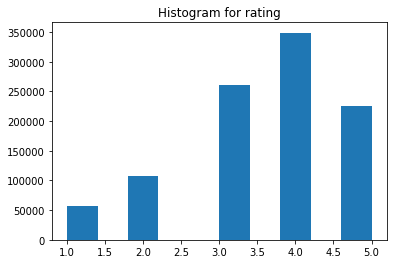

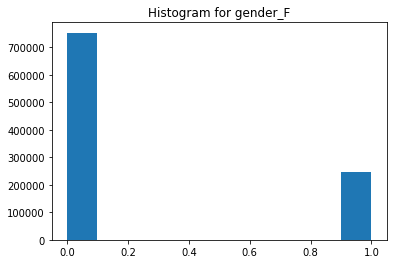

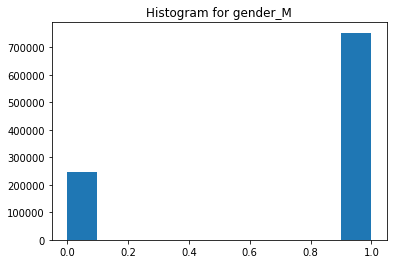

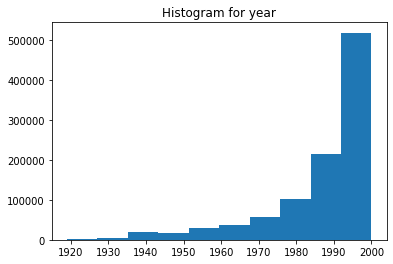

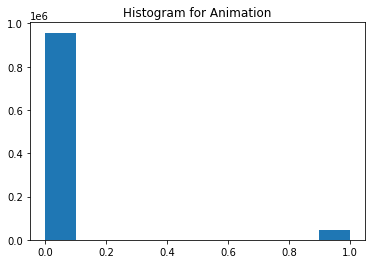

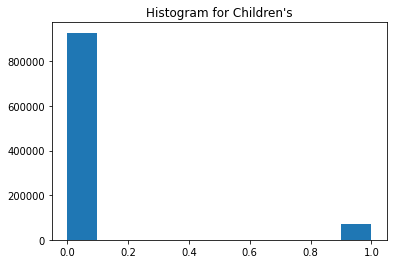

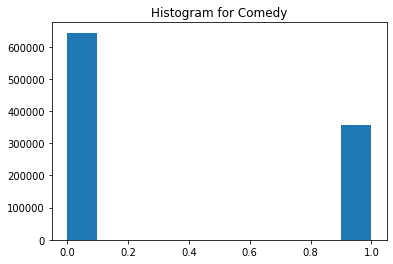

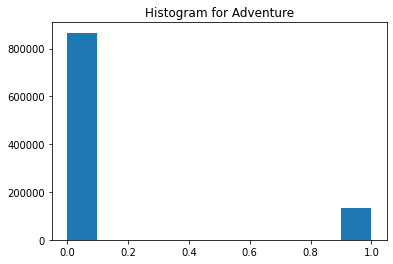

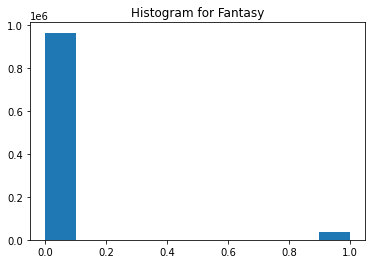

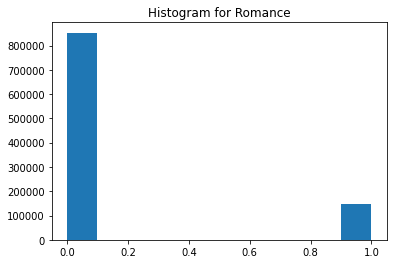

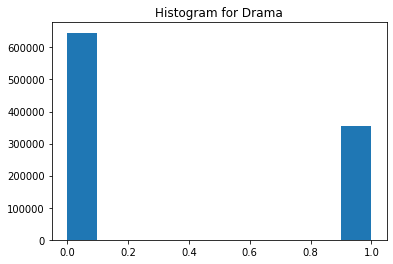

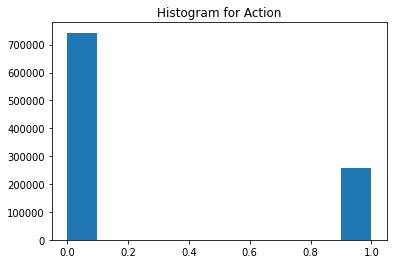

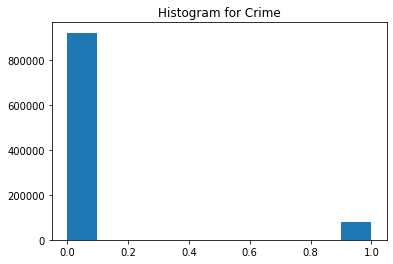

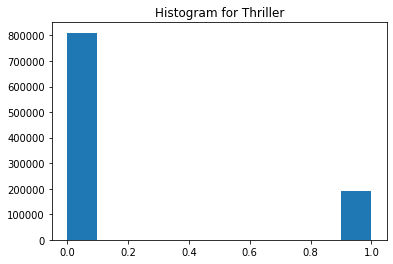

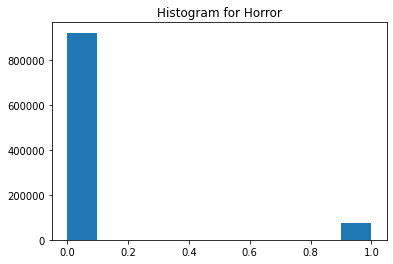

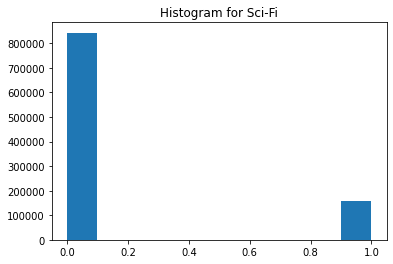

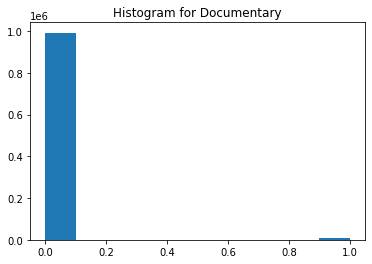

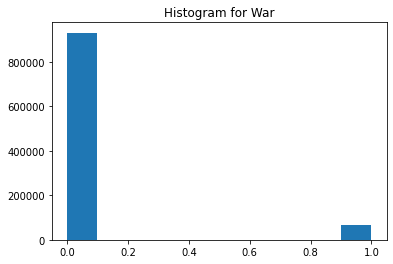

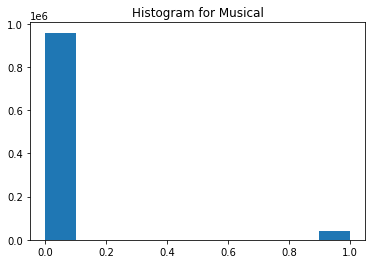

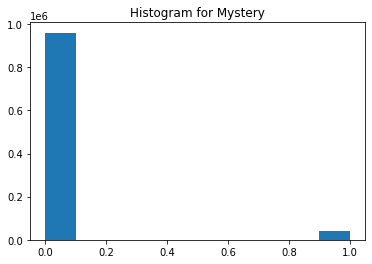

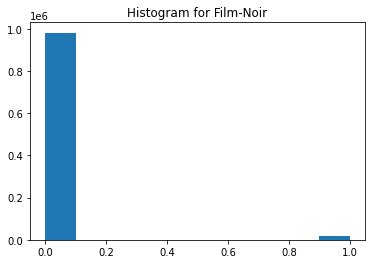

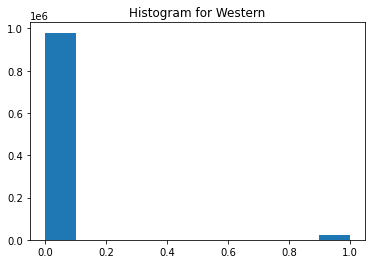

In [507]:
plotHistogram(data)

### Scaling the dataset

We scale the data because we want to have a $similarity \in [0,2]$ 

In [508]:
from sklearn.preprocessing import MinMaxScaler

In [509]:
scaler = MinMaxScaler()

In [510]:
data.columns

Index(['user_id', 'movie_id', 'rating', 'gender_F', 'gender_M', 'year',
       'Animation', 'Children's', 'Comedy', 'Adventure', 'Fantasy', 'Romance',
       'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Sci-Fi',
       'Documentary', 'War', 'Musical', 'Mystery', 'Film-Noir', 'Western'],
      dtype='object')

In [511]:
data[['year']] = scaler.fit_transform(data[['year']])
data

c:\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\python36\lib\site-packages\pandas\core\indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


,user_id,movie_id,rating,gender_F,gender_M,year,Animation,Children's,Comedy,Adventure,...,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,0.0,1176,5.0,1.0,0.0,0.691358,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1176,5.0,0.0,1.0,0.691358,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11.0,1176,4.0,0.0,1.0,0.691358,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14.0,1176,4.0,0.0,1.0,0.691358,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16.0,1176,5.0,0.0,1.0,0.691358,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,5948.0,2129,5.0,0.0,1.0,0.975309,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1000205,5674.0,2634,3.0,0.0,1.0,0.975309,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000206,5779.0,2776,1.0,0.0,1.0,0.987654,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000207,5850.0,3538,5.0,1.0,0.0,0.666667,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [512]:
data.columns

Index(['user_id', 'movie_id', 'rating', 'gender_F', 'gender_M', 'year',
       'Animation', 'Children's', 'Comedy', 'Adventure', 'Fantasy', 'Romance',
       'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Sci-Fi',
       'Documentary', 'War', 'Musical', 'Mystery', 'Film-Noir', 'Western'],
      dtype='object')

In [513]:
genre_cols = ["Animation", "Children's", 
       'Comedy', 'Adventure', 'Fantasy', 'Romance', 'Drama',
       'Action', 'Crime', 'Thriller', 'Horror', 'Sci-Fi', 'Documentary', 'War',
       'Musical', 'Mystery', 'Film-Noir', 'Western']

In [514]:
selectedCols = ['gender_F', 'gender_M', 'year'] #+ genre_cols
max_rows = 1000 # we concentrate only on first 200 users to avoid numpy memory issues.

data_minified = data[:max_rows]
data_minified

,user_id,movie_id,rating,gender_F,gender_M,year,Animation,Children's,Comedy,Adventure,...,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,0.0,1176,5.0,1.0,0.0,0.691358,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1176,5.0,0.0,1.0,0.691358,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11.0,1176,4.0,0.0,1.0,0.691358,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14.0,1176,4.0,0.0,1.0,0.691358,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16.0,1176,5.0,0.0,1.0,0.691358,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3591.0,1176,5.0,1.0,0.0,0.691358,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,3593.0,1176,4.0,0.0,1.0,0.691358,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,3595.0,1176,5.0,1.0,0.0,0.691358,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,3599.0,1176,5.0,0.0,1.0,0.691358,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [515]:
selectedCols

['gender_F', 'gender_M', 'year']

In [516]:
similarity_user = computeAllSimilarities(data_minified, selectedCols)
similarity_user

array([[1.47797592, 0.47797592, 0.47797592, ..., 1.47797592, 0.47797592,
        1.47797592],
       [0.47797592, 1.47797592, 1.47797592, ..., 0.47797592, 1.47797592,
        0.47797592],
       [0.47797592, 1.47797592, 1.47797592, ..., 0.47797592, 1.47797592,
        0.47797592],
       ...,
       [1.47797592, 0.47797592, 0.47797592, ..., 1.47797592, 0.47797592,
        1.47797592],
       [0.47797592, 1.47797592, 1.47797592, ..., 0.47797592, 1.47797592,
        0.47797592],
       [1.47797592, 0.47797592, 0.47797592, ..., 1.47797592, 0.47797592,
        1.47797592]])

In [517]:
similarity_with_user1 = similarity_user[0]

(array([745.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 255.]),
 array([0.47797592, 0.57797592, 0.67797592, 0.77797592, 0.87797592,
        0.97797592, 1.07797592, 1.17797592, 1.27797592, 1.37797592,
        1.47797592]),
 <BarContainer object of 10 artists>)

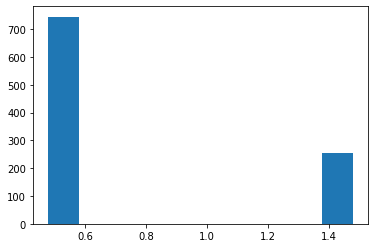

In [518]:
plt.hist(similarity_with_user1)

### Comments :

More than 20% of users are similar to user 1.

# Conclusion:
 
We have implemented a version of recommandation based on similarity between users. After that we thought of adding also user similarity in the pipeline in orther to have more accuracy. There's still some work to do in this last part.